### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:

train_data = pd.read_csv('lab1_train.csv', delimiter=',')
test_data = pd.read_csv('lab1_test.csv', delimiter=',')


# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')


/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


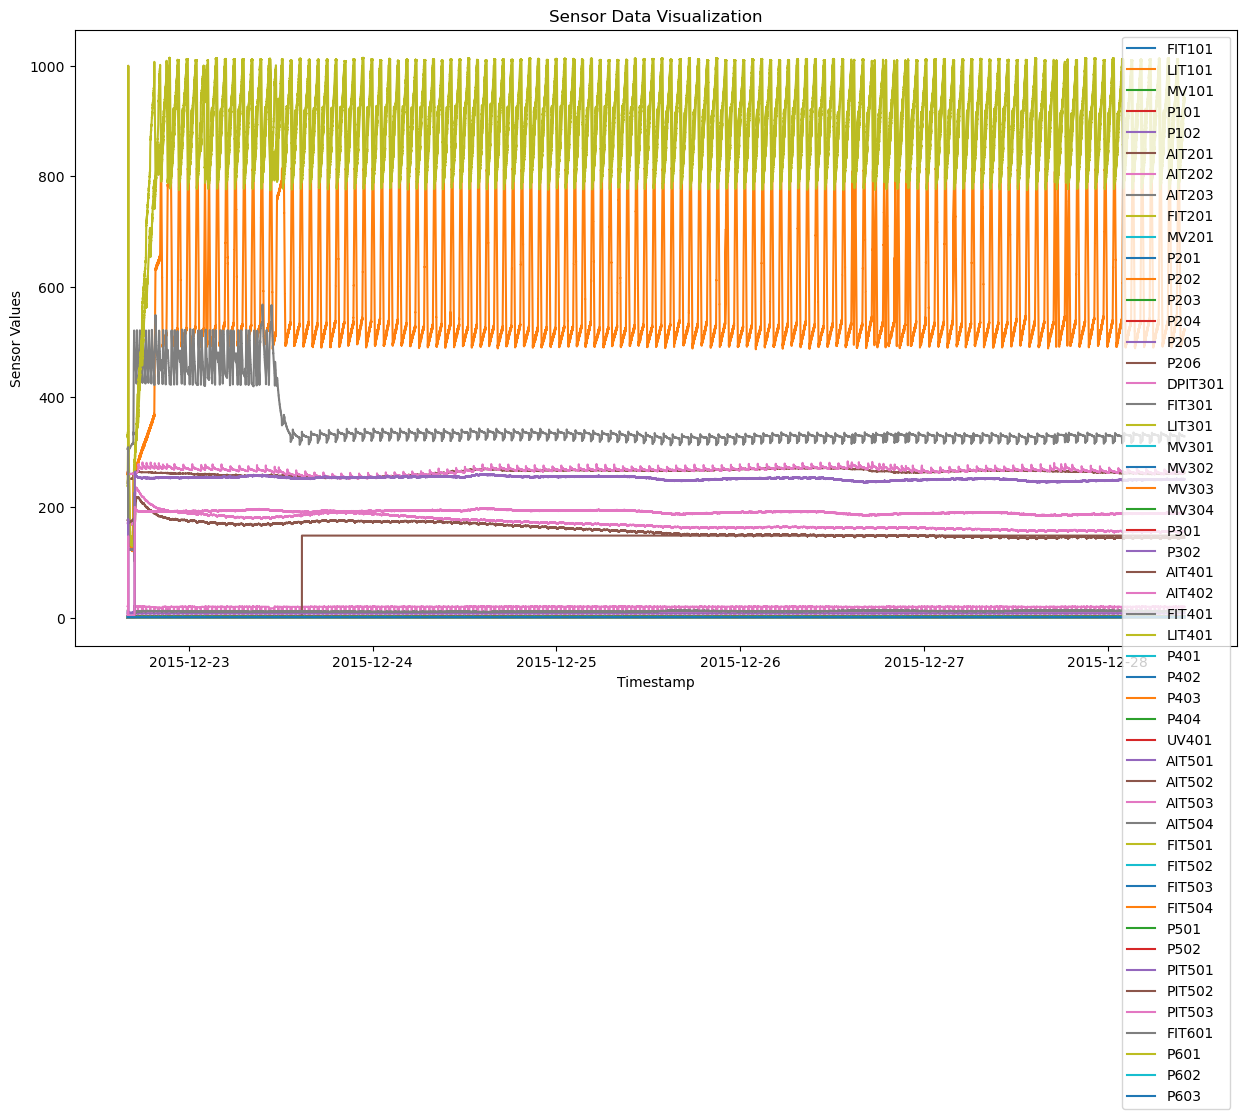

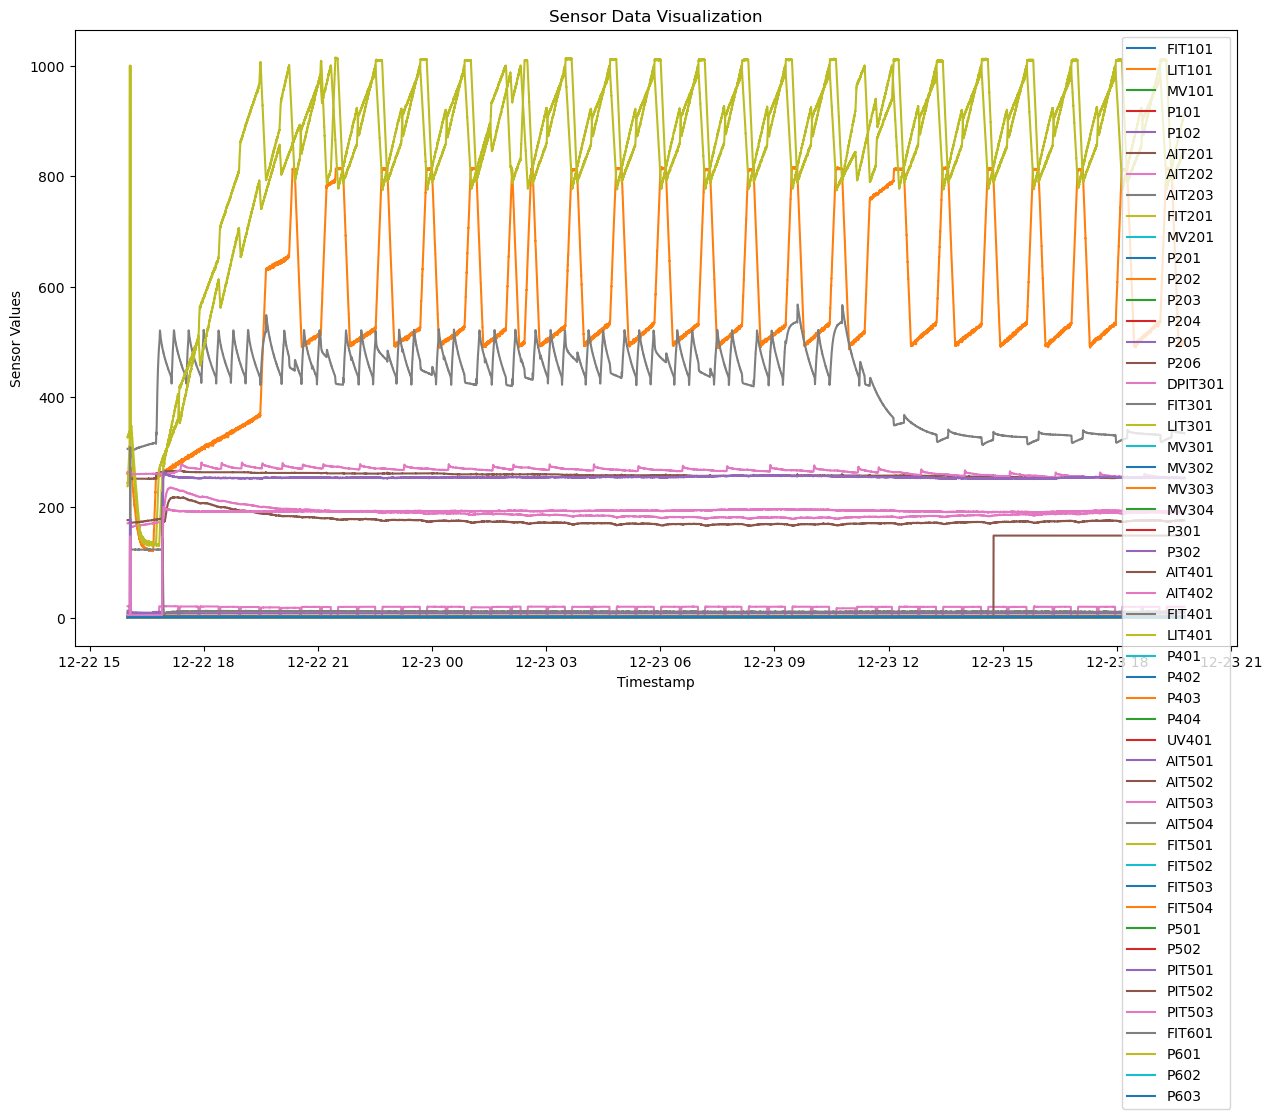

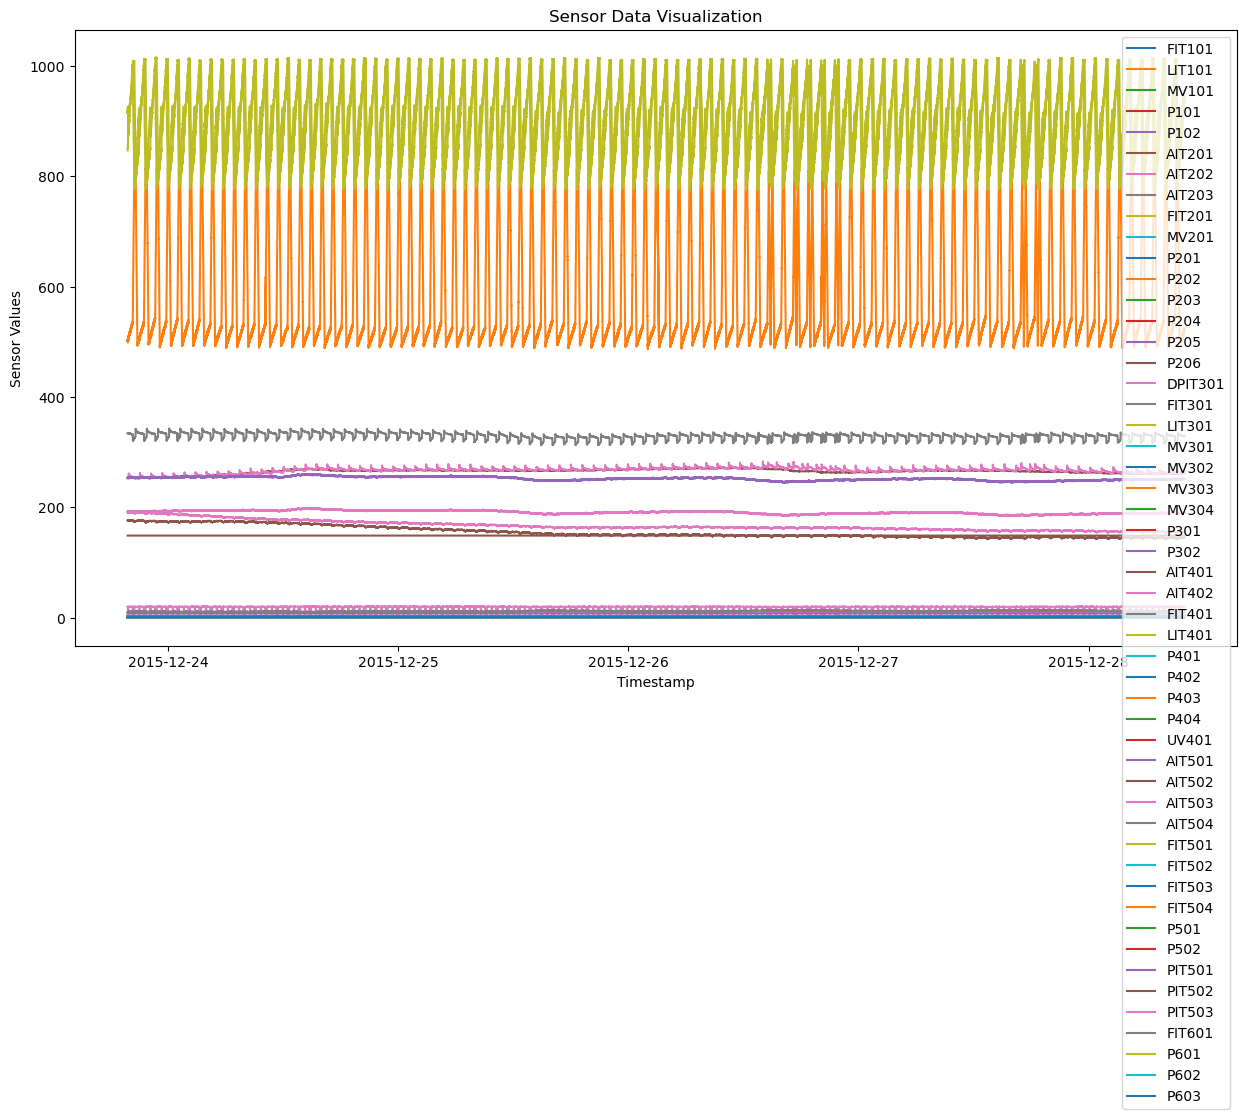

In [4]:
def visualize_sensor_data(df, window=None, sensors=None, title="Sensor Data Visualization"):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()

    plt.show()

# visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
# visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)
visualize_sensor_data(train_data, window=(0, 100000))
visualize_sensor_data(train_data, window=(100000, 1000000))

#### Observations
After observing these plots we can group the signals into 3 categories

- Value < 50
- 50 <= Value <= 300 
- Value > 300

So the next step is to visualize these groups

In [5]:
time_stamp = train_data.iloc[:, 0]
norm_attack = train_data.iloc[:, -1:]
sensors = train_data.iloc[:, 1:-1]

higher_range  = sensors.loc[:, (sensors.mean() > 300 ) | (sensors.max()  > 300)]
mid_range     = sensors.loc[:, (sensors.mean() >= 50 ) & (sensors.mean() <= 300)]
lower_range   = sensors.loc[:, (sensors.mean() < 50  ) & (sensors.max()  < 300) & (sensors.mean() > 5)]
lowest_range  = sensors.loc[:, (sensors.mean() <= 5  ) ]

higher_range_data = pd.concat([time_stamp, higher_range, norm_attack], axis=1)
mid_range_data    = pd.concat([time_stamp, mid_range, norm_attack], axis=1)
lower_range_data  = pd.concat([time_stamp, lower_range, norm_attack], axis=1)
lowest_range_data = pd.concat([time_stamp, lowest_range, norm_attack], axis=1)


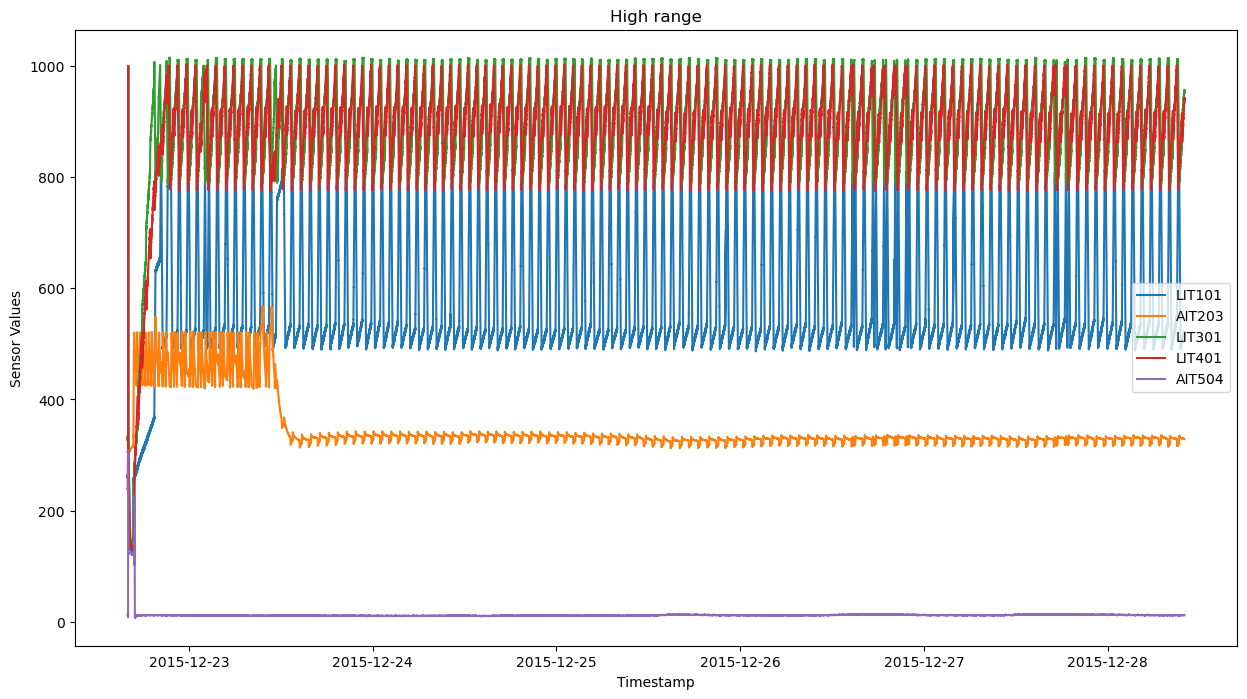

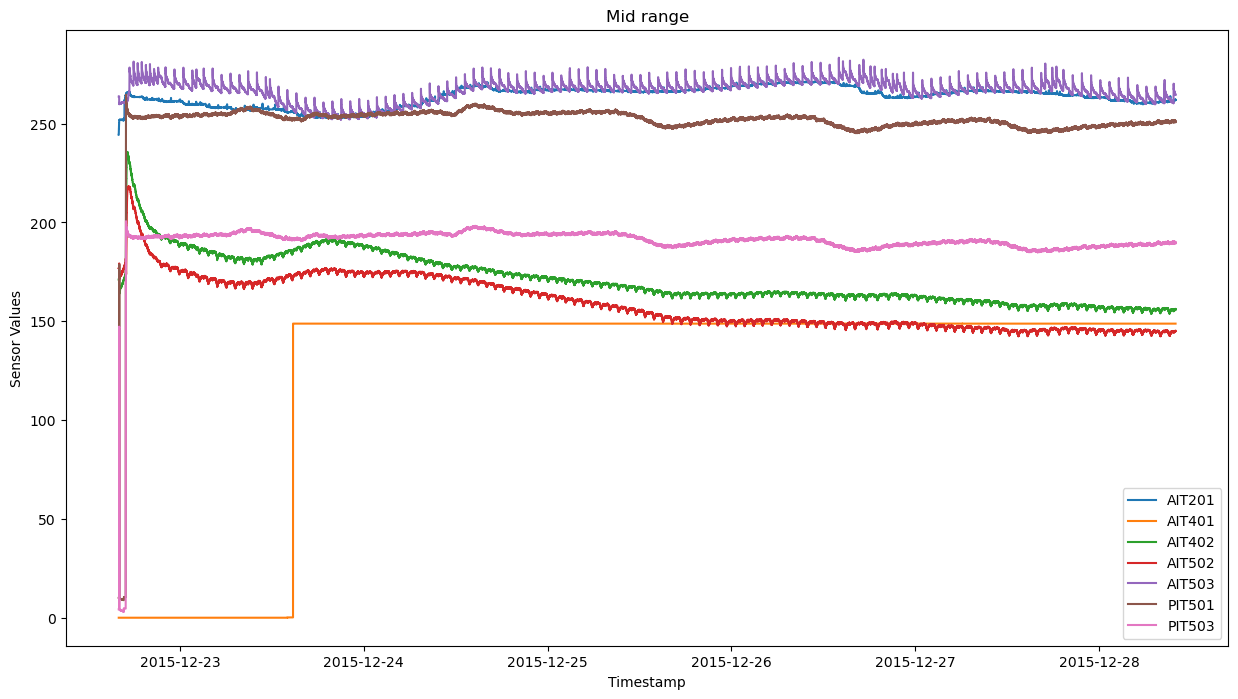

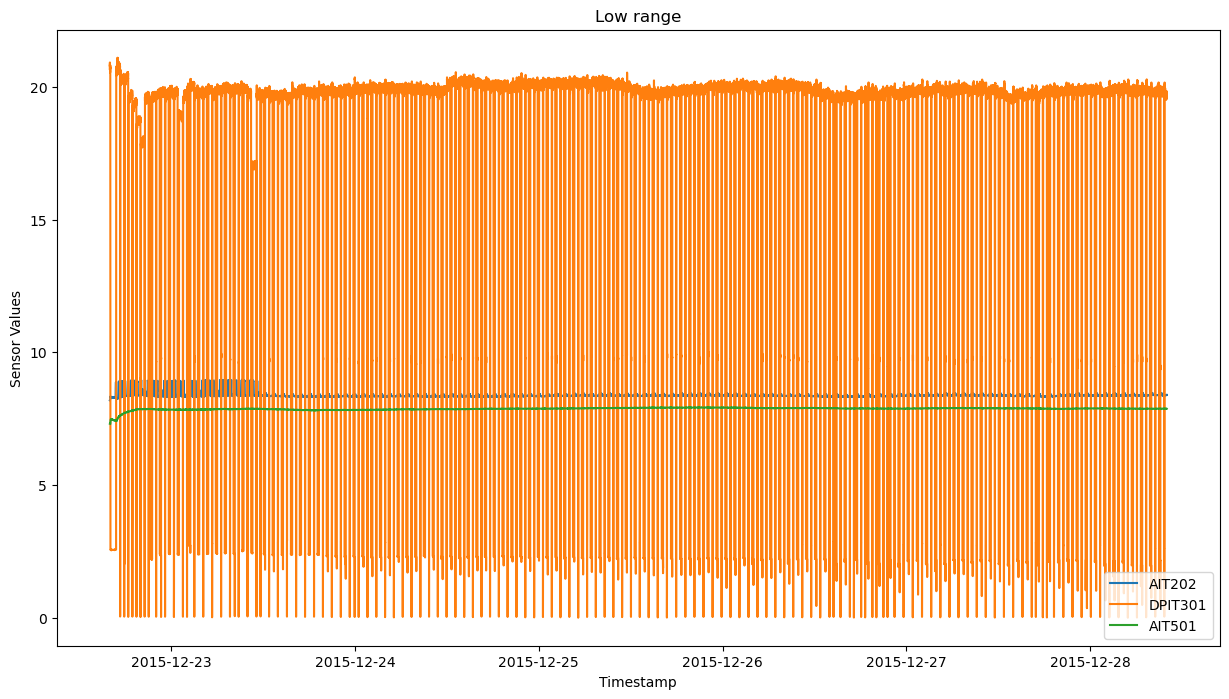

/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


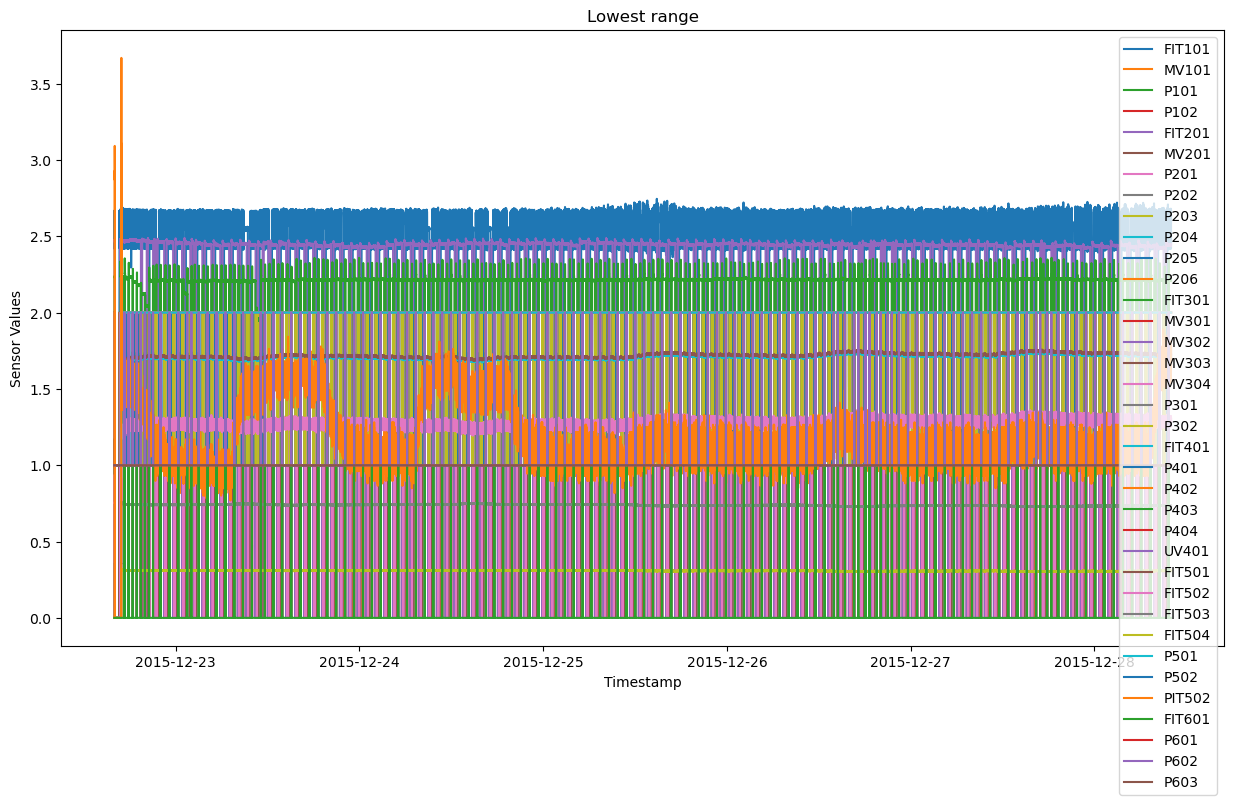

In [6]:
visualize_sensor_data(higher_range_data[:-1], title="High range")
visualize_sensor_data(mid_range_data[:-1],    title="Mid range")
visualize_sensor_data(lower_range_data[:-1],  title="Low range")
visualize_sensor_data(lowest_range_data[:-1], title="Lowest range")


In [7]:
datasets = {
    "Original Data": train_data,
    "Higher Range Data": higher_range_data,
    "Mid Range Data": mid_range_data,
    "Lower Range Data": lower_range_data,
    "Lowest Range Data": lowest_range_data,
}

for name, data in datasets.items():
    print(f"{name}:")
    print(f"Column Names: {list(data.columns)}")
    print(f"(Adjusted) Column Count: {len(data.columns) - 2}")
    print("-" * 50)

Original Data:
Column Names: ['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack']
(Adjusted) Column Count: 51
--------------------------------------------------
Higher Range Data:
Column Names: ['Timestamp', 'LIT101', 'AIT203', 'LIT301', 'LIT401', 'AIT504', 'Normal/Attack']
(Adjusted) Column Count: 5
--------------------------------------------------
Mid Range Data:
Column Names: ['Timestamp', 'AIT201', 'AIT401', 'AIT402', 'AIT502', 'AIT503', 'PIT501', 'PIT503', 'Normal/Attack']
(Adjusted) Column Count: 7
---------------------------------------------

Unfortenately the majority of the data is still in the same range,which makes individual sensors harder to follow
So we split it into 3

In [8]:

split_count = 3
splits = [pd.concat([time_stamp, lowest_range_data[cols]],axis=1) for cols in np.array_split(lowest_range_data.columns.to_list()[1:], split_count)]


/nix/store/4vmqc642fjam58ap7zpkg38hmaj2nyha-python3.12-ipython-8.29.0/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


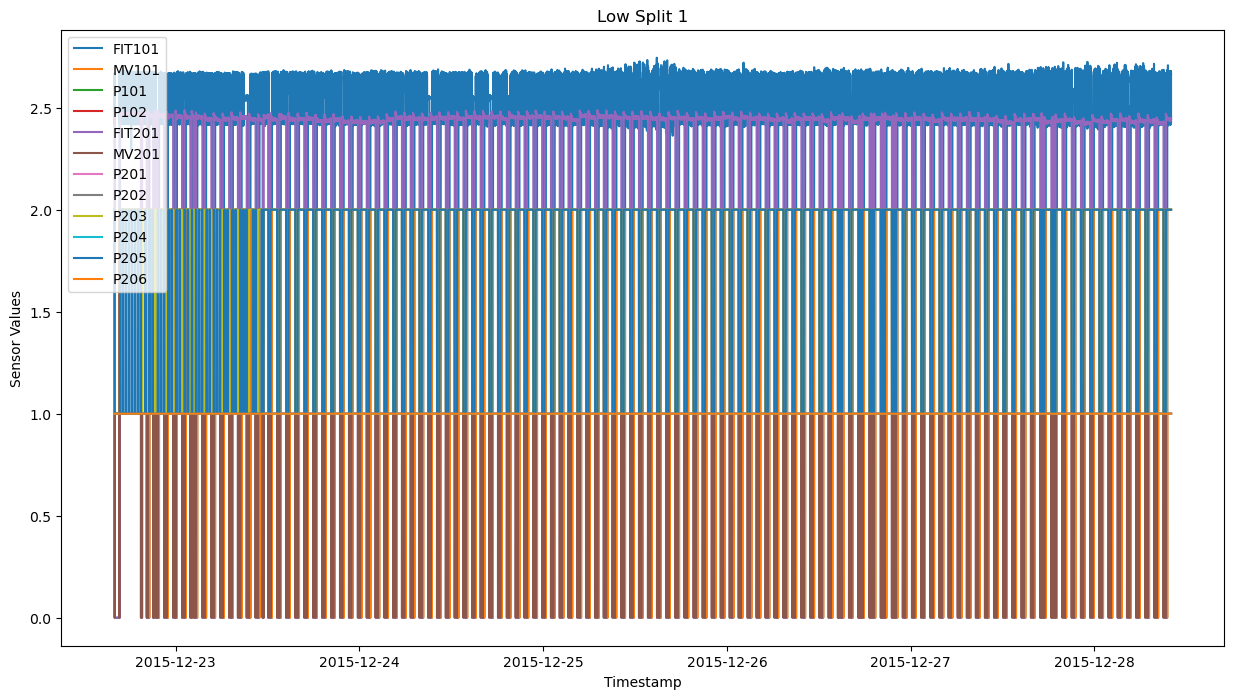

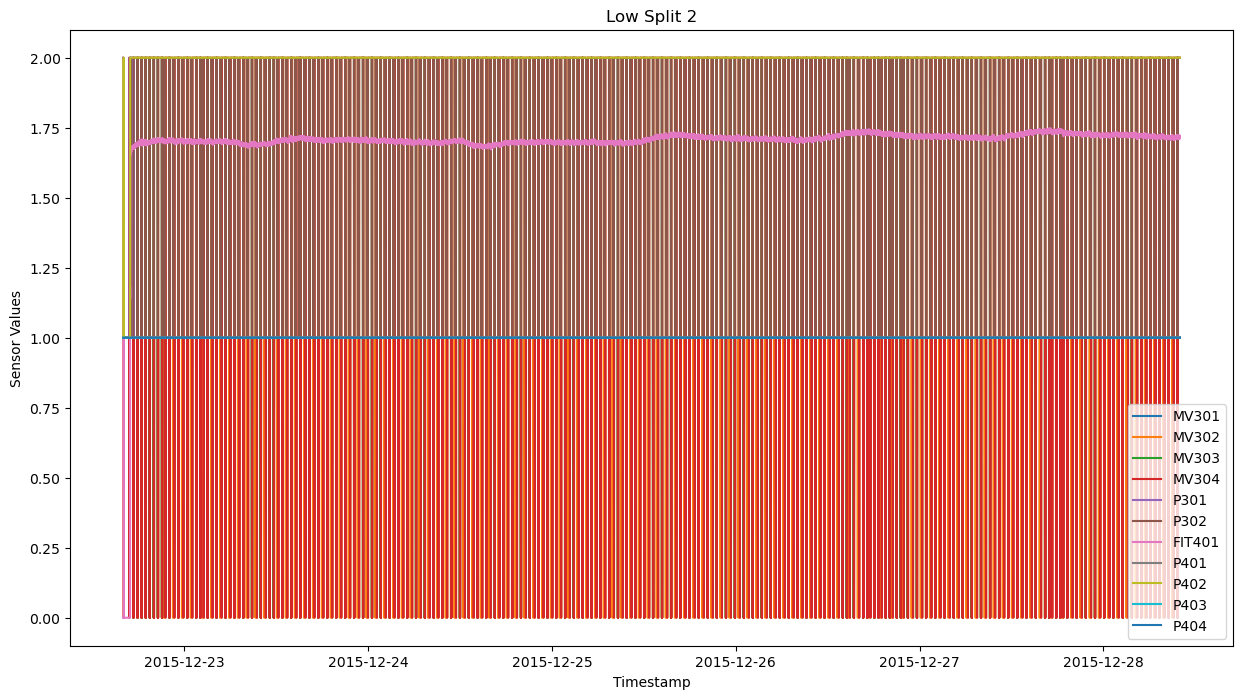

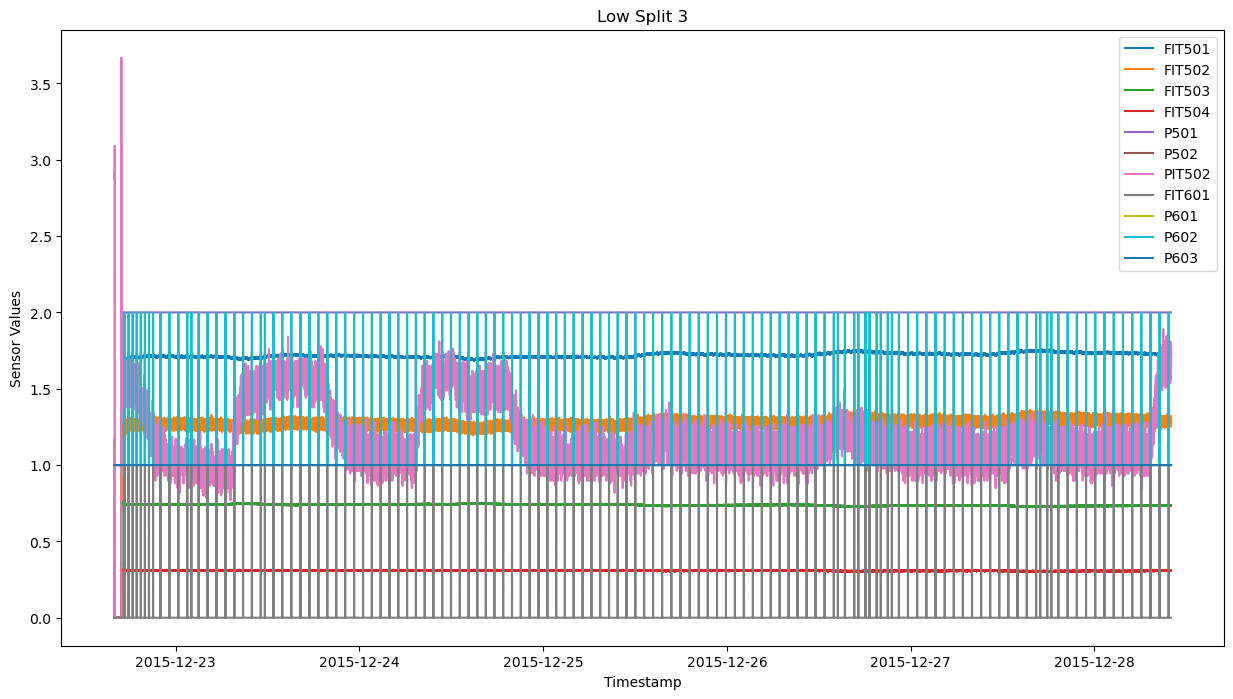

In [9]:
for i, split in enumerate(splits):
  visualize_sensor_data(split[:-1], title=f"Low Split {i + 1}")


Now we can see the differences between signals more clearly

Key takaways are:
- The majority of the signals are constant and periodic
- Not every signal howeever, some stay flat with ocasionally large jumps



# DTW
---

I picked signal "FIT101" because it looked interesting 

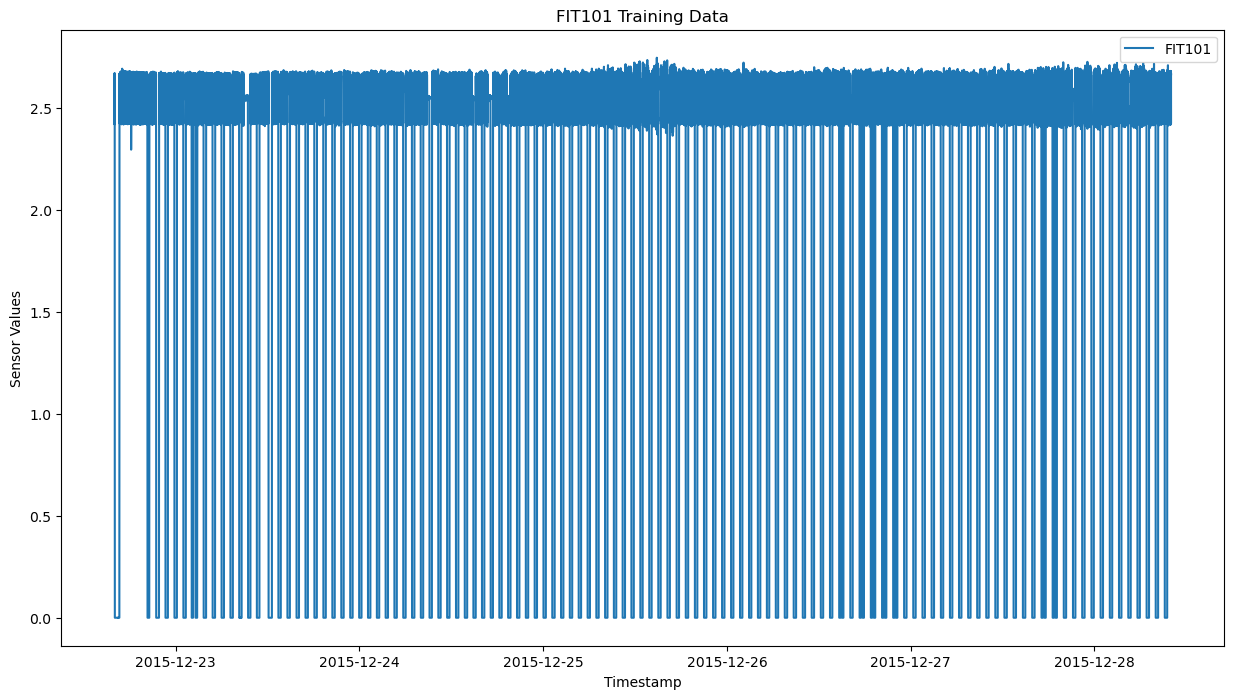

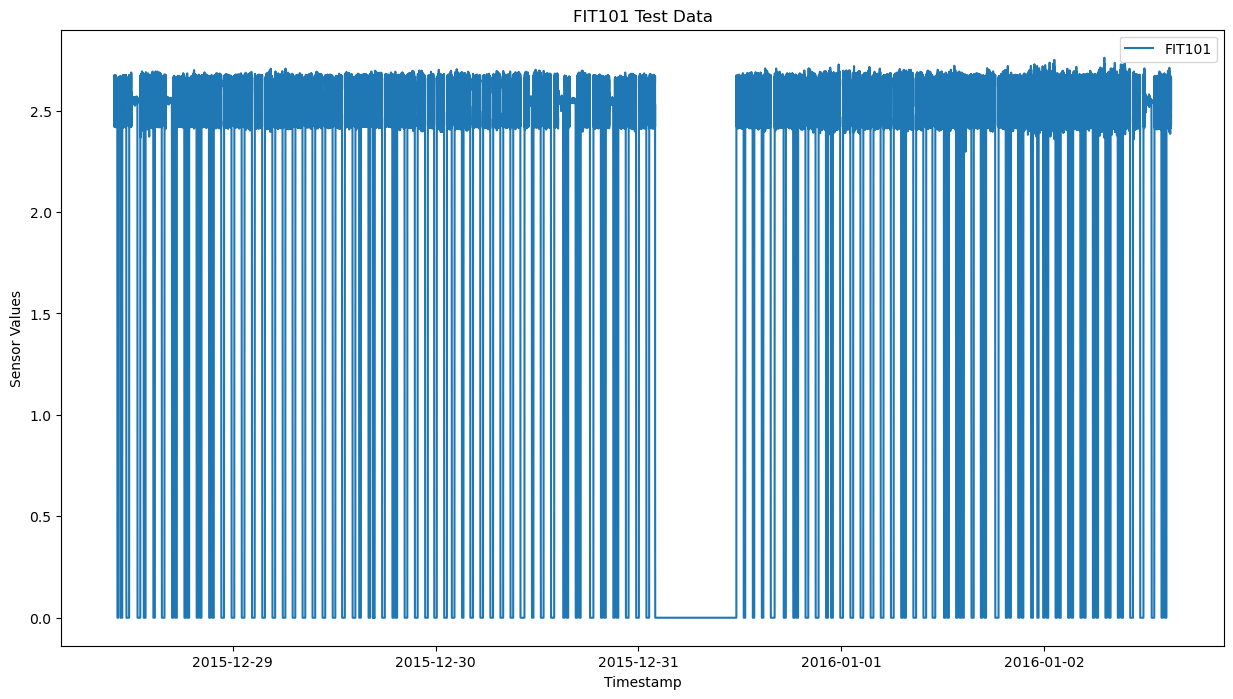

In [10]:
visualize_sensor_data(train_data, title=f"FIT101 Training Data", sensors=["FIT101"])
visualize_sensor_data(test_data, title=f"FIT101 Test Data", sensors=["FIT101"])


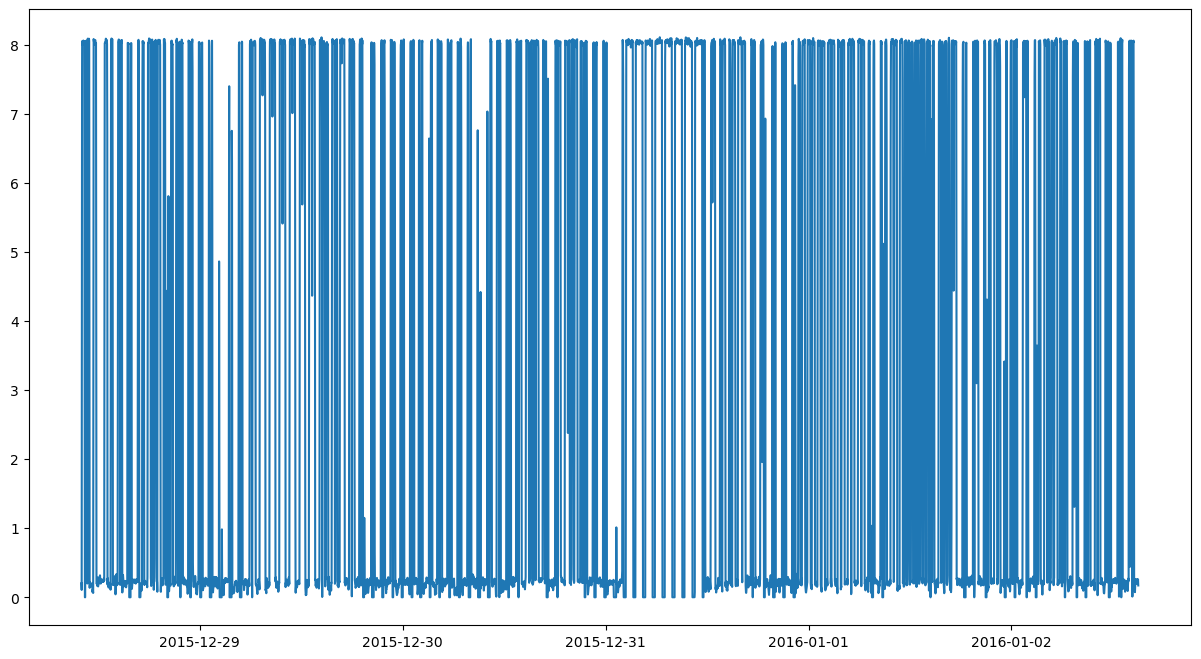

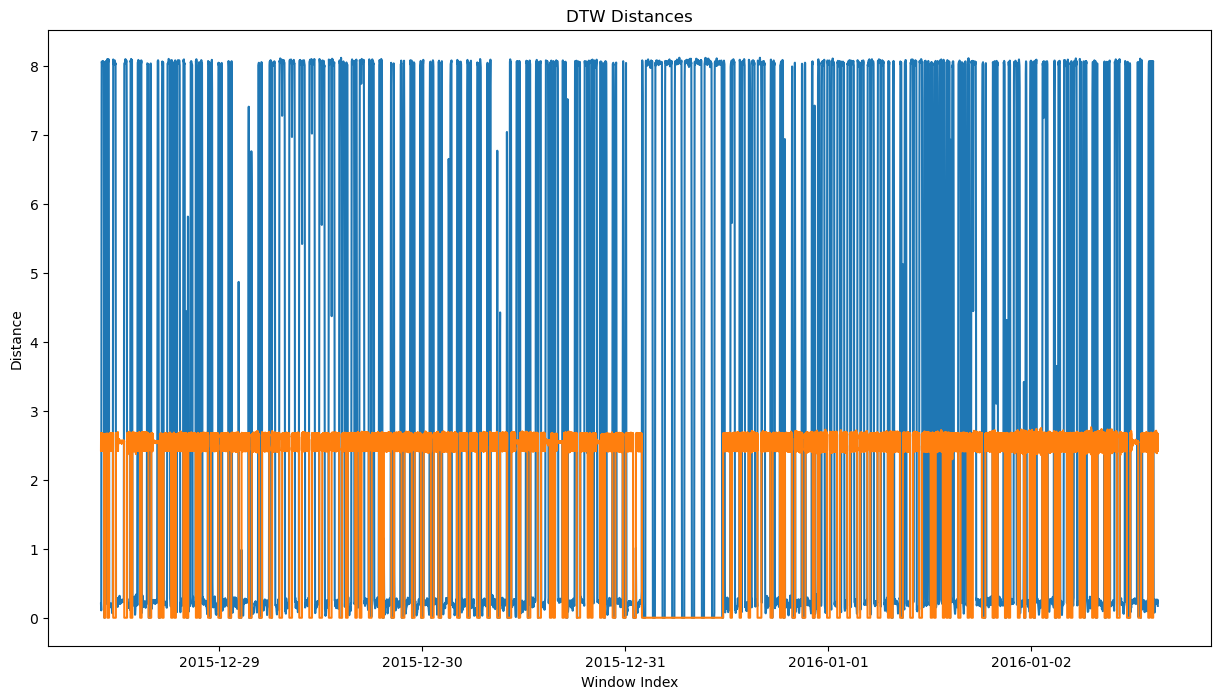

In [11]:
import math

def dynamic_time_warping(s, t):
    n = s.size
    m = t.size
    
    DTW = np.full([n + 1, m + 1], np.inf)
    DTW[0, 0] = 0

    for y in range(1, n + 1):
        for x in range(1, m + 1):
            cost = abs(s[y-1] - t[x-1])**2
            DTW[y, x] = cost + min(DTW[y-1][x], DTW[y][x-1], DTW[y-1][x-1])
    return math.sqrt(DTW[n, m])



def sample_window(window_size, sample_count):
  return np.linspace(0, window_size-1, sample_count).astype(int)

def create_window(data, signal,window_size, stride, sample_idx, max_window_count=np.inf):
  out = []
  count = 0
  data_size = len(data)
  for i in range(0,data_size - window_size, window_size + stride):
    window = data[signal][i:i+window_size]
    sample = window.iloc[sample_idx].values
    out.append(sample)
    
    if count >= max_window_count:
      break 
    count = count + 1
  return out

train_sample_count = 10
test_sample_count = 10
train_window_size = 100
test_window_size = 100

train_sample_idx = sample_window(train_window_size, train_sample_count) 
test_sample_idx = sample_window(test_window_size, test_sample_count) 

train_windows = create_window(train_data,"FIT101",train_window_size, 0,train_sample_idx)
test_windows  = create_window(test_data, "FIT101",test_window_size , 0,test_sample_idx)

distances = []
for train, test in zip(train_windows, test_windows):
  distance = dynamic_time_warping(train, test)
  distances.append(distance)

window_indices = np.arange(len(distances))

train_time_stamp = train_data.iloc[:, 0]
test_time_stamp = test_data.iloc[:, 0]

train_signal = train_data["FIT101"]
test_signal = test_data["FIT101"]

stretched = np.linspace(0, len(distances)-1, test_signal.size)
interpolated_distances = np.interp(stretched, np.arange(len(distances)), distances)

plt.figure(figsize=(15, 8))
plt.plot(test_time_stamp, interpolated_distances)
plt.show()

plt.figure(figsize=(15, 8))

# plt.plot(interpolated_distances)
plt.plot(test_time_stamp, interpolated_distances)
plt.plot(test_time_stamp, test_signal)

plt.title("DTW Distances")
plt.xlabel("Window Index")
plt.ylabel("Distance")
plt.show()


# PCA
---
For PCA we will use another signal, LIT101

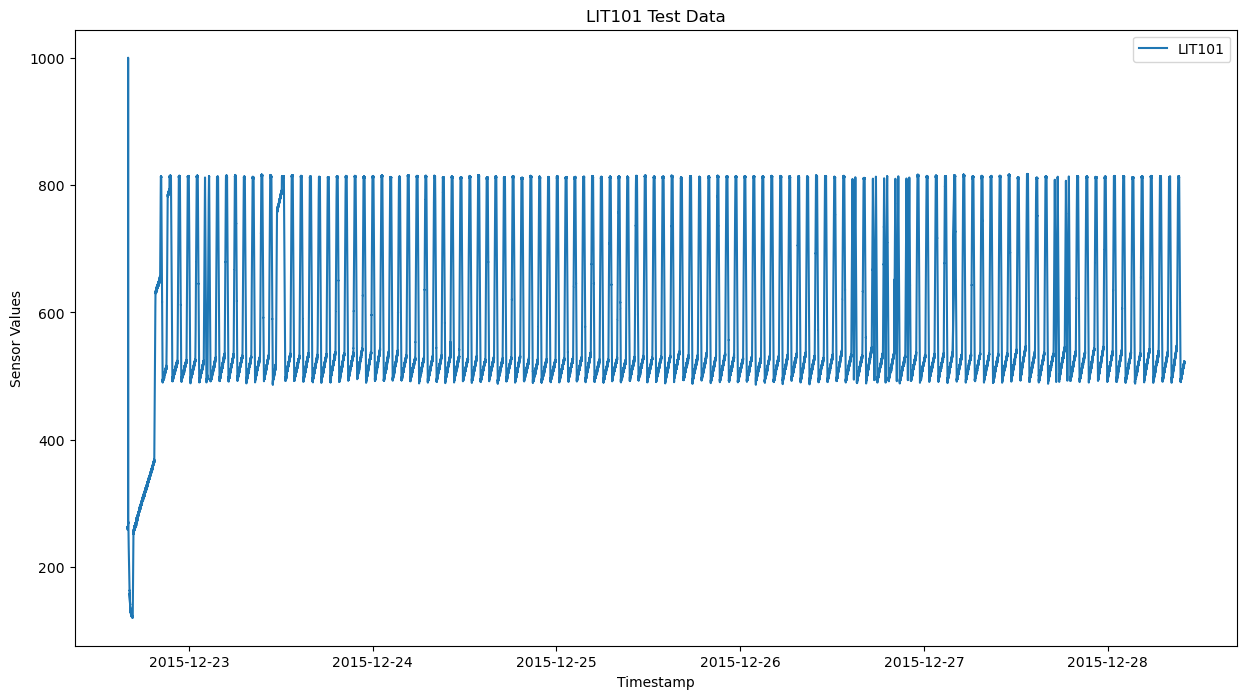

In [13]:
visualize_sensor_data(train_data, title=f"LIT101 Test Data", sensors=["LIT101"])


In [37]:


train_sample_count = 10
test_sample_count = 10
train_window_size = 100
test_window_size = 100

train_sample_idx = sample_window(train_window_size, train_sample_count) 
test_sample_idx = sample_window(test_window_size, test_sample_count) 

train_windows = create_window(train_data,"FIT101",train_window_size, 0,train_sample_idx)
test_windows  = create_window(test_data, "FIT101",test_window_size , 0,test_sample_idx)



def principal_component_analysis(df, k):
    cov = np.cov(df, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    top_k_idx = sorted_idx[:k]
    selected_eigenvectors = eigenvectors[:, top_k_idx]

    reduced_data = np.dot(df, selected_eigenvectors)
    
    return reduced_data, selected_eigenvectors
    
def reconstruct_data(reduced_data, eigenvectors):
    return np.dot(reduced_data, eigenvectors.T)

def compute_residuals(original_data, reconstructed_data):
    return np.linalg.norm(original_data - reconstructed_data, axis=1)



def normalize(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return (data - mean) / std, mean, std


train_signal, mean, std = normalize(train_data)
test_signal = (test_data - mean) / std


residuals_train_all = []


residuals = []
for train, test in zip(train_windows, test_windows):
  reduced_train, eigenvectors = principal_component_analysis(train_signal, component_count)
  reconstructed_train = reconstruct_data(reduced_train, eigenvectors)
  residuals_window = compute_residuals(train_signal, reconstructed_train)
  residuals.append(residuals_train)


plt.figure(figsize=(15, 8))
plt.plot(residuals, label=f'PCA')

plt.xlabel('Data Point Index')
plt.ylabel('Residual')
plt.title('PCA Residuals')
plt.legend()
plt.show()


LinAlgError: Array must not contain infs or NaNs